# Mesh pre-processing with VEDO

## Libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import pymeshlab
import math
import vedo
import logging
from tqdm import tqdm
import shutil



## Global variables

In [2]:
# Outlier thresholds
LOW_THRESHOLD = 500
HIGH_THRESHOLD = 10000

# Dataset Selection
USE_FULL_DATA = False

# Override
OVERWRITE = True

# Tolerance level
TOLERANCE = 0.2

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(levelname)s]: %(message)s', datefmt='%H:%M:%S')
logger = logging.getLogger()

# Dataset and Output paths
DATASET_PATH = 'DATASET/DATASET_SNIPPET'
RESAMPLED_SHAPES_PATH = 'RESAMPLED_SHAPES'
OUTPUT_PATH = 'OUTPUTS'

# Function to handle directory creation with optional overwrite
def create_directory(path, overwrite=False, logger=logger):
    """
    Create a directory. If overwrite is True, delete the directory if it exists and recreate it.
    Parameters:
        path (str): The path of the directory to create.
        overwrite (bool): Whether to overwrite the directory if it exists.
    """
    if overwrite and os.path.exists(path):
        # Remove the directory and its contents if overwrite is True
        shutil.rmtree(path)
        logger.info(f"Directory '{path}' existed and was removed for overwriting.")
    
    # Now create the directory
    os.makedirs(path, exist_ok=True)
    logger.info(f"Directory '{path}' created.")


# Create OUTPUT, RESAMPLED_SHAPES directories and CSV paths 
create_directory(OUTPUT_PATH, overwrite=OVERWRITE, logger=logger)
create_directory(RESAMPLED_SHAPES_PATH, overwrite=OVERWRITE, logger=logger)

original_csv_path = os.path.join(OUTPUT_PATH, "shapes_data.csv")
resampled_csv_path = os.path.join(OUTPUT_PATH, "resampled_shapes_data.csv")

# Counter of shapes excluded
EXCLUDED = 0

04:38:15 [INFO]: Directory 'OUTPUTS' existed and was removed for overwriting.
04:38:15 [INFO]: Directory 'OUTPUTS' created.
04:38:15 [INFO]: Directory 'RESAMPLED_SHAPES' existed and was removed for overwriting.
04:38:15 [INFO]: Directory 'RESAMPLED_SHAPES' created.


## Database analyzation functions

In [3]:
def get_face_type(mesh):
    """
    Determine the type of faces in the mesh.

    Parameters:
        mesh (vedo.Mesh): The mesh object to analyze.

    Returns:
        str: A string describing the face type ("Triangles", "Quads", or "Mixed").
    """
    # Get the faces from the mesh
    face_array = mesh.cells  # Renaming the variable to avoid conflict
    face_sizes = [len(face) for face in face_array]

    if all(size == 3 for size in face_sizes):
        return "Triangles"
    elif all(size == 4 for size in face_sizes):
        return "Quads"
    else:
        return "Mixed"

    

def analyze_shape(filepath, low_threshold=500, high_threshold=10000):
    """
    Analyze a 3D shape using Vedo and return the required information.

    Parameters:
        filepath (str): Path to the OBJ file.
        low_threshold (int, optional): Threshold for low vertex count outliers. Defaults to 500.
        high_threshold (int, optional): Threshold for high vertex count outliers. Defaults to 10000.
    Returns:
        dict: A dictionary containing shape analysis results.
    """
    logger.info(f"Analyzing shape: '{filepath}'")
    try:
        # Load the mesh from the file
        mesh = vedo.Mesh(filepath)

        # Ensure the loaded object is a Mesh
        if not isinstance(mesh, vedo.Mesh):
            logger.warning(f"File '{filepath}' is not a valid mesh. Skipping.")
            return None

        # Get number of vertices and faces
        num_vertices = mesh.npoints
        num_faces = mesh.ncells
        
        # Get face type
        face_type = get_face_type(mesh)

        # Get bounding box
        bounding_box = mesh.bounds()

        # Determine if mesh has holes (Vedo doesn't provide a direct method, so we keep it hardcoded)
        has_holes = False  # Placeholder, you might need to implement a method to check for holes

        # Determine outlier status based on vertex count
        outlier_low = num_vertices <= low_threshold
        outlier_high = num_vertices >= high_threshold

        # Log detailed information
        logger.debug(f"Vertices: {num_vertices}, Faces: {num_faces}, Face Type: {face_type}")

        return {
            "vertices": num_vertices,
            "faces": num_faces,
            "face_type": face_type,
            "bounding_box": {
                "min_bound": [bounding_box[0], bounding_box[2], bounding_box[4]],
                "max_bound": [bounding_box[1], bounding_box[3], bounding_box[5]]
            },
            "has_holes": has_holes,
            "outlier_low": outlier_low,
            "outlier_high": outlier_high
        }

    except Exception as e:
        logger.error(f"Error analyzing shape '{filepath}': {e}")
        return None


def analyze_database(db_path):
    """
    Iteratively analyze all 3D shapes within the database.

    Parameters:
        labeled_db_path (str): Path to the root of the labeled database.
    Returns:
        list: A list of dictionaries containing shape analysis results.
    """
    logger.info(f"Starting analysis of database at '{db_path}'")
    results = []

    for category in os.listdir(db_path):
        category_path = os.path.join(db_path, category)

        if os.path.isdir(category_path):
            logger.info(f"Processing category: '{category}'")
            for shape_file in os.listdir(category_path):
                if shape_file.lower().endswith('.obj'):
                    filepath = os.path.join(category_path, shape_file)
                    shape_info = {
                        "file_name": shape_file,
                        "obj_class": category,
                        "file_path": filepath
                    }
                    analysis_result = analyze_shape(filepath, high_threshold=HIGH_THRESHOLD, low_threshold=LOW_THRESHOLD)
                    if analysis_result:
                        shape_info.update(analysis_result)
                        results.append(shape_info)
                    else:
                        logger.warning(f"Skipping file '{filepath}' due to previous errors.")

    logger.info("Database analysis complete.")
    return results

## Resampling and Remeshing functions

In [4]:
def adjust_mesh_complexity(mesh, row, target_vertices=5000, max_iterations=10):
    """
    Adjust mesh complexity by refining low-poly meshes and simplifying high-poly meshes.

    Parameters:
        mesh (vedo.Mesh): The mesh object to adjust.
        row (dict): Dictionary containing outlier information (whether low or high outlier).
        target_vertices (int): Target number of vertices.
        max_iterations (int): Maximum number of iterations allowed.
    Returns:
        vedo.Mesh: The adjusted and cleaned mesh object.
    """
    current_vertices = mesh.npoints
    
    # If it's a high outlier (more vertices than target), reduce complexity using quadric decimation
    if row["outlier_high"]:
        logger.info(f"Simplifying high complexity mesh (Current vertices: {current_vertices})...")
        mesh = simplify_high_complexity_mesh(mesh, target_vertices, max_iterations)

    # Apply isotropic remeshing to all meshes (refinement for low and high complexity)
    logger.info(f"Refining mesh to have around {target_vertices} vertices (Current vertices: {current_vertices})...")
    mesh = resample_with_isotropic_remeshing(mesh, target_vertices, max_iterations)

    return mesh


def simplify_high_complexity_mesh(mesh, target_vertices=5000, max_iterations=20):
    """
    Simplify high complexity meshes using quadric edge collapse decimation.

    Parameters:
        mesh (vedo.Mesh): The mesh object to simplify.
        target_vertices (int): Target number of vertices.
        max_iterations (int): Maximum number of iterations allowed.
    Returns:
        vedo.Mesh: The simplified mesh object.
    """
    current_vertices = mesh.npoints

    for i in range(max_iterations):
        logger.info(f"Decimation: Iteration {i + 1}: Current vertices: {current_vertices}")
        
        # Calculate the target percentage for this iteration
        if current_vertices > target_vertices * 2:
            # When far from the target, reduce by 50%
            target_perc = 0.5  
        elif current_vertices > target_vertices * 1.5:
            # When getting closer to the target, reduce by 25%
            target_perc = 0.75  
        else:
            # When very close, reduce by 10%
            target_perc = 0.90  

        # If we're close to the target, adjust the target percentage
        if current_vertices * target_perc < target_vertices:
            target_perc = target_vertices / current_vertices

        # Apply quadric edge collapse decimation
        mesh = mesh.decimate(fraction=target_perc)

        previous_vertices = current_vertices
        current_vertices = mesh.npoints

        # Check if the current number of vertices is within the desired tolerance
        if abs(current_vertices - target_vertices) / target_vertices < TOLERANCE:
            logger.info(f"Target reached: {current_vertices} vertices (within tolerance of {target_vertices}).")
            break

        # If the number of vertices hasn't changed significantly, break
        if abs(current_vertices - previous_vertices) < 10:
            logger.warning(f"Number of vertices did not change significantly after iteration {i + 1}.")
            break

    # Final check if target was reached
    if abs(current_vertices - target_vertices) / target_vertices >= TOLERANCE:
        logger.warning(f"Could not reach target vertex count after {max_iterations} iterations. Final vertex count: {current_vertices}.")

    return mesh


def resample_with_isotropic_remeshing(vedo_mesh, target_vertices=5000, max_iterations=10, tolerance=0.2, verbose=True):
    """
    Use PyMeshLab isotropic remeshing to adjust the number of vertices in the mesh with iterative refinement.

    Parameters:
        vedo_mesh (vedo.Mesh): The mesh object to resample.
        target_vertices (int): Target number of vertices.
        max_iterations (int): Maximum number of iterations allowed.
        tolerance (float): Tolerance level for vertex count.
        verbose (bool): Print additional logs.

    Returns:
        vedo.Mesh: The resampled vedo.Mesh object or original if refinement fails.
    """
    try:
        # Step 1: Convert Vedo mesh to PyMeshLab-compatible format (OBJ)
        temp_path = 'temp_input_mesh.obj'
        vedo_mesh.write(temp_path)
        logger.info(f"Converted Vedo mesh to PyMeshLab-compatible format at '{temp_path}'.")

        ms = pymeshlab.MeshSet()
        ms.load_new_mesh(temp_path)

        # Step 2: Initial Setup for Resampling
        current_vertices = ms.current_mesh().vertex_number()
        initial_edge_length = compute_initial_edge_length(ms)
        target_edge_length = initial_edge_length

        logger.info(f"Starting isotropic remeshing with {current_vertices} vertices. Target: {target_vertices} vertices.")

        lower_bound = target_vertices * (1 - tolerance)
        upper_bound = target_vertices * (1 + tolerance)

        for i in range(max_iterations):
            if verbose:
                logger.info(f"Isotropic: Iteration {i + 1}: Current vertices: {current_vertices}")

            # Apply isotropic remeshing
            ms.apply_filter('meshing_isotropic_explicit_remeshing', 
                            targetlen=pymeshlab.PureValue(target_edge_length),
                            iterations=1)
            
            current_vertices = ms.current_mesh().vertex_number()

            # Check if the current number of vertices is within the desired tolerance of the target vertices
            if lower_bound <= current_vertices <= upper_bound:
                logger.info(f"Target reached: {current_vertices} vertices.")
                break

            # Adjust the target edge length based on the ratio of current vertices to target
            if current_vertices > target_vertices:
                scaling_factor = 1.2  # Increase edge length to reduce vertices
            else:
                scaling_factor = 0.8  # Decrease edge length to add more vertices

            target_edge_length *= scaling_factor
            target_edge_length = max(0.001, min(1.0, target_edge_length))  # Limit the edge length

        # Step 3: Convert PyMeshLab mesh back to Vedo mesh
        remeshed_temp_path = 'remeshed_temp_output.obj'
        ms.save_current_mesh(remeshed_temp_path)
        logger.info(f"Remeshed PyMeshLab mesh saved temporarily at '{remeshed_temp_path}'.")

        remeshed_vedo_mesh = vedo.load(remeshed_temp_path)
        logger.info(f"Loaded remeshed mesh back into Vedo.")

        # Cleanup temporary files
        os.remove(temp_path)
        os.remove(remeshed_temp_path)

        return remeshed_vedo_mesh

    except Exception as e:
        logger.error(f"Error during isotropic remeshing: {str(e)}")
        return vedo_mesh  # Return original mesh if any error occurs


def compute_initial_edge_length(ms):
    """
    Compute an initial edge length based on the mesh's bounding box diagonal.
    This helps to normalize the edge length across different scales.

    Parameters:
        ms (pymeshlab.MeshSet): The PyMeshLab mesh object to compute the edge length for.
    Returns:
        float: Initial edge length based on the bounding box diagonal.
    """
    bbox = ms.current_mesh().bounding_box()
    diag = math.sqrt((bbox.dim_x() ** 2) + (bbox.dim_y() ** 2) + (bbox.dim_z() ** 2))

    # Make the initial edge length more conservative based on the diagonal size
    initial_edge_length = diag / 100  # Adjust divisor as needed (smaller values increase initial detail)
    
    # Clamp to prevent overly large or small initial edge lengths
    initial_edge_length = max(0.01, min(1.0, initial_edge_length))
    
    return initial_edge_length


## Mesh Cleaning


In [5]:
def clean_mesh(mesh):
    """
    Clean the mesh by removing duplicate faces and vertices, repairing holes, and ensuring consistent orientation.

    Parameters:
        mesh (vedo.Mesh): The mesh object to clean.
    Returns:
        vedo.Mesh or None: The cleaned mesh object, or None if the mesh cannot be cleaned.
    """
    logger.info(f"Starting cleaning of mesh with {mesh.npoints} vertices and {mesh.ncells} faces.")

    try:
        # Make a copy of the mesh to avoid modifying the original
        mesh = mesh.clone()

        # Remove duplicate points (vertices) and unused points
        mesh.clean()
        logger.debug("Removed duplicate and unused vertices.")

        # Triangulate mesh to ensure it consists of triangles
        mesh.triangulate()
        logger.debug("Triangulated mesh faces.")

        # Fill holes in the mesh
        # Note: 'size' parameter defines the maximum hole size to fill; 'None' fills all holes
        mesh.fill_holes()
        logger.debug("Filled holes in the mesh.")

        # Remove small connected components (keep the largest one)
        mesh = mesh.extract_largest_region()
        logger.debug("Extracted the largest connected component.")

        # Check if the mesh has any faces left
        if mesh.ncells == 0:
            logger.warning("Mesh has no faces left after cleaning.")
            return None

        logger.info(f"Finished cleaning. Mesh now has {mesh.npoints} vertices and {mesh.ncells} faces.")
        return mesh

    except Exception as e:
        logger.error(f"Error during mesh cleaning: {e}")
        return None

## Central preprocessing functions

In [6]:
def is_manifold(mesh):
    '''
    Check if the mesh is manifold.
    :param ms: pymeshlab.MeshSet object
    :return: Boolean indicating if the mesh is manifold
    '''
    
    return mesh.is_manifold()



def process_meshes(df, resampled_root):
    """
    Process and resample meshes, save valid ones, and skip invalid ones.

    Parameters:
        df (pd.DataFrame): DataFrame containing information about each mesh to process.
        resampled_root (str): Root directory to save resampled meshes.

    Returns:
        pd.DataFrame: DataFrame of valid processed meshes.
        pd.DataFrame: DataFrame of skipped meshes.
    """
    global EXCLUDED
    valid_rows = []
    skipped_rows = []

    for _, row in df.iterrows():
        obj_class = row['obj_class']
        file_name = row['file_name']
        file_path = row['file_path']
        resampled_file_path = os.path.join(resampled_root, obj_class, file_name)

        try:
            # Load the mesh using Vedo
            mesh = vedo.Mesh(file_path)
            if not isinstance(mesh, vedo.Mesh):
                logger.warning(f"File '{file_path}' is not a valid mesh. Skipping.")
                skipped_rows.append(row)
                continue

            logger.info(f"Processing mesh: {file_path}")

            # Clean the mesh
            cleaned_mesh = clean_mesh(mesh)

            # Check if the mesh is manifold
            if not is_manifold(cleaned_mesh):
                logger.warning(f"Mesh '{file_name}' is non-manifold.")
                # skipped_rows.append(row)
                # continue

            # Adjust the mesh complexity
            resampled_mesh = adjust_mesh_complexity(cleaned_mesh, row)
            
            if resampled_mesh == None:
                EXCLUDED += 1
                continue

            # Ensure the directory for resampled file exists
            os.makedirs(os.path.dirname(resampled_file_path), exist_ok=True)

            # Save the resampled mesh
            resampled_mesh.write(resampled_file_path)
            logger.info(f"Saved resampled mesh to {resampled_file_path}")

            # Add the row to valid rows
            valid_rows.append(row)

        except Exception as e:
            logger.error(f"Error processing mesh {file_path}: {str(e)}")
            skipped_rows.append(row)

    logger.info(f"Successfully processed {len(valid_rows)} meshes.")
    logger.info(f"Skipped {len(skipped_rows)} meshes.")

    return pd.DataFrame(valid_rows), pd.DataFrame(skipped_rows)


## Visualization

In [7]:
# Visualize
def plot_distribution(df, title, bins=30):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(df['vertices'], bins=bins, color='purple', alpha=0.7)
    plt.title(f'{title} - Distribution of Vertices')
    plt.xlabel('Number of Vertices')
    plt.ylabel('Number of Shapes')
    plt.subplot(1, 2, 2)
    plt.hist(df['faces'], bins=bins, color='red', alpha=0.7)
    plt.title(f'{title} - Distribution of Faces')
    plt.xlabel('Number of Faces')
    plt.ylabel('Number of Shapes')
    plt.tight_layout()
    plt.show()

# Statistics
def compare_statistics(original_df, resampled_df):
    print("Statistics comparison:")
    for column in ['vertices', 'faces']:
        print(f"\n{column.capitalize()}:")
        print("Before Resampling:")
        print(original_df[column].describe())
        print("\nAfter Resampling:")
        print(resampled_df[column].describe())


## Main

04:38:16 [INFO]: Analyzing database and collecting statistics...
04:38:16 [INFO]: Starting analysis of database at 'DATASET/DATASET_SNIPPET'
04:38:16 [INFO]: Processing category: 'AircraftBuoyant'
04:38:16 [INFO]: Analyzing shape: 'DATASET/DATASET_SNIPPET\AircraftBuoyant\m1341.obj'
04:38:16 [INFO]: Analyzing shape: 'DATASET/DATASET_SNIPPET\AircraftBuoyant\m1342.obj'
04:38:16 [INFO]: Analyzing shape: 'DATASET/DATASET_SNIPPET\AircraftBuoyant\m1348.obj'
04:38:16 [INFO]: Analyzing shape: 'DATASET/DATASET_SNIPPET\AircraftBuoyant\m1351.obj'
04:38:16 [INFO]: Processing category: 'Apartment'
04:38:16 [INFO]: Analyzing shape: 'DATASET/DATASET_SNIPPET\Apartment\D00681.obj'
04:38:16 [INFO]: Analyzing shape: 'DATASET/DATASET_SNIPPET\Apartment\D00780.obj'
04:38:16 [INFO]: Analyzing shape: 'DATASET/DATASET_SNIPPET\Apartment\D00859.obj'
04:38:16 [INFO]: Analyzing shape: 'DATASET/DATASET_SNIPPET\Apartment\D00869.obj'
04:38:16 [INFO]: Processing category: 'AquaticAnimal'
04:38:16 [INFO]: Analyzing shap

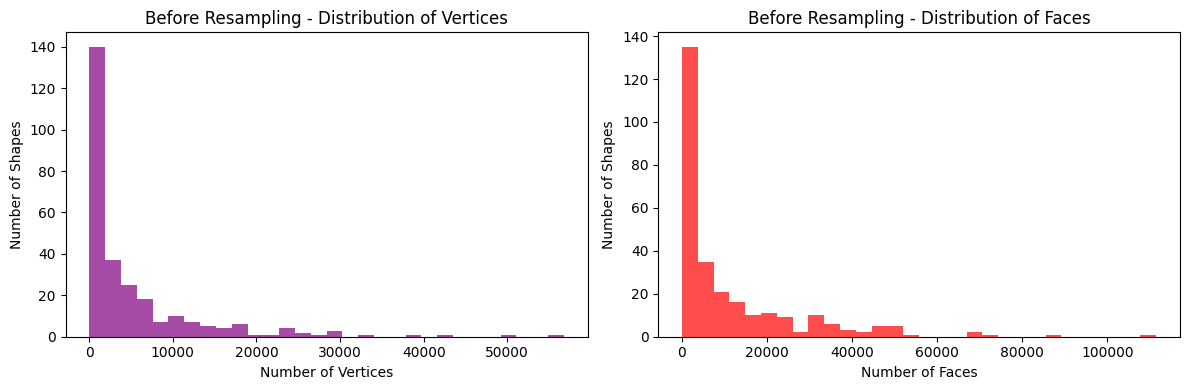

04:38:23 [INFO]: Starting resampling of shapes...
Processing Batches:   0%|          | 0/3 [00:00<?, ?it/s]04:38:23 [INFO]: 
Processing batch 1 of 3...
04:38:23 [INFO]: Processing mesh: DATASET/DATASET_SNIPPET\AircraftBuoyant\m1341.obj
04:38:23 [INFO]: Starting cleaning of mesh with 425 vertices and 824 faces.
04:38:23 [INFO]: Finished cleaning. Mesh now has 424 vertices and 408 faces.
04:38:23 [INFO]: Refining mesh to have around 5000 vertices (Current vertices: 424)...
04:38:23 [INFO]: Converted Vedo mesh to PyMeshLab-compatible format at 'temp_input_mesh.obj'.
04:38:23 [INFO]: Starting isotropic remeshing with 424 vertices. Target: 5000 vertices.
04:38:23 [INFO]: Isotropic: Iteration 1: Current vertices: 424
04:38:23 [INFO]: Isotropic: Iteration 2: Current vertices: 694
04:38:23 [INFO]: Isotropic: Iteration 3: Current vertices: 2267
04:38:23 [INFO]: Isotropic: Iteration 4: Current vertices: 6715
04:38:24 [INFO]: Isotropic: Iteration 5: Current vertices: 8223
04:38:24 [INFO]: Isotrop

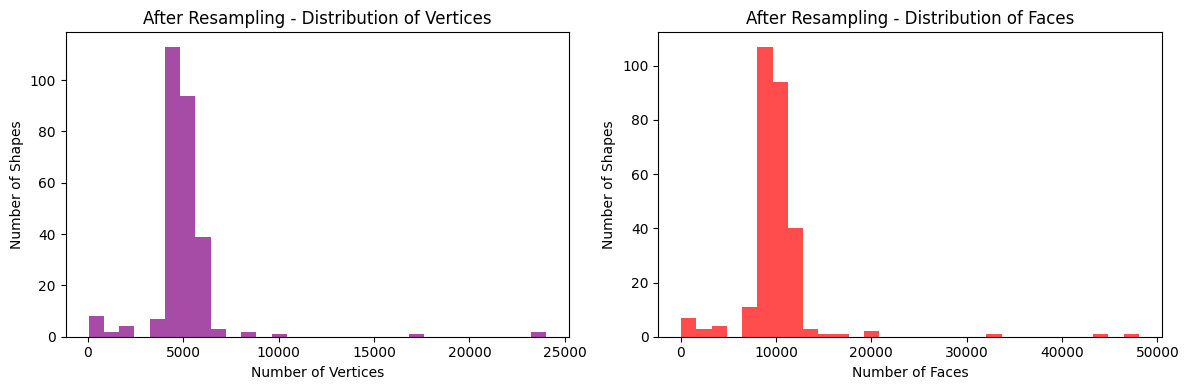

04:40:41 [INFO]: 
Total outlier meshes skipped: 0


Statistics comparison:

Vertices:
Before Resampling:
count      276.000000
mean      5275.126812
std       8236.467231
min         16.000000
25%        624.000000
50%       1850.000000
75%       5990.750000
max      56754.000000
Name: vertices, dtype: float64

After Resampling:
count      276.000000
mean      4995.391304
std       2111.694668
min         45.000000
25%       4444.250000
50%       4882.000000
75%       5460.500000
max      24029.000000
Name: vertices, dtype: float64

Faces:
Before Resampling:
count       276.000000
mean      11321.760870
std       16120.337136
min          16.000000
25%        1194.000000
50%        4184.500000
75%       14851.750000
max      111471.000000
Name: faces, dtype: float64

After Resampling:
count      276.000000
mean      9953.460145
std       4187.752222
min         53.000000
25%       8801.500000
50%       9735.000000
75%      10906.250000
max      48054.000000
Name: faces, dtype: float64


In [8]:
def main():
    """
    Main function to analyze, resample, and collect statistics on 3D shape datasets.
    """

    # -------------------------------------------- ANALYZE ORIGINAL SHAPES -------------------------------------------- #
    if not os.path.exists(original_csv_path) or OVERWRITE:
        logger.info("Analyzing database and collecting statistics...")
        shapes_data = analyze_database(DATASET_PATH)
        shapes_data_df = pd.DataFrame(shapes_data)
        shapes_data_df.to_csv(original_csv_path, index=False)
        logger.info(f"Original shapes data saved to '{original_csv_path}'")
    else:
        shapes_data_df = pd.read_csv(original_csv_path)
        logger.info(f"Loaded existing original shapes data from '{original_csv_path}'")

    plot_distribution(shapes_data_df, "Before Resampling")

    # ----------------------------------------------- RESAMPLING SHAPES ----------------------------------------------- #
    if not os.path.exists(RESAMPLED_SHAPES_PATH) or OVERWRITE:
        logger.info("Starting resampling of shapes...")

        # Determine batch size based on dataset selection
        batch_size = 500 if USE_FULL_DATA else 100

        skipped_shapes_list = []

        total_batches = (len(shapes_data_df) + batch_size - 1) // batch_size
        for i in tqdm(range(0, len(shapes_data_df), batch_size), desc="Processing Batches"):
            batch_number = i // batch_size + 1
            logger.info(f"\nProcessing batch {batch_number} of {total_batches}...")
            batch = shapes_data_df.iloc[i:i + batch_size]
            _, skipped_batch = process_meshes(batch, RESAMPLED_SHAPES_PATH)
            skipped_shapes_list.append(skipped_batch)

        logger.info(f"Resampled shapes saved to '{RESAMPLED_SHAPES_PATH}'")

        # Save skipped shapes data
        skipped_df = pd.concat(skipped_shapes_list, ignore_index=True)
        skipped_csv_path = os.path.join(OUTPUT_PATH, "skipped_shapes_data.csv")
        skipped_df.to_csv(skipped_csv_path, index=False)
        logger.warning(f"Skipped shapes data saved to '{skipped_csv_path}'")
    else:
        logger.info(f"Resampled shapes folder '{RESAMPLED_SHAPES_PATH}' already exists. Analyzing existing resampled shapes.")

    # ------------------------------------------- ANALYZE RESAMPLED SHAPES ------------------------------------------- #
    logger.info("Analyzing resampled database and collecting statistics...")
    resampled_shapes_data = analyze_database(RESAMPLED_SHAPES_PATH)
    resampled_shapes_df = pd.DataFrame(resampled_shapes_data)

    # Save or update the resampled shapes data
    resampled_shapes_df.to_csv(resampled_csv_path, index=False)
    logger.info(f"Resampled shapes data saved to '{resampled_csv_path}'")

    plot_distribution(resampled_shapes_df, "After Resampling")
    compare_statistics(shapes_data_df, resampled_shapes_df)

    logger.info(f"\nTotal outlier meshes skipped: {EXCLUDED}")

if __name__ == "__main__":
    main()